In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
from utils.functions import load_data
from infopath.lick_classifier import prepare_classifier
from utils.functions import return_trial_type, pear_corr, explained, trial_metric, trial_type_perc
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from utils.plot_utils import plot_with_size, strip_right_top_axis, hit_miss_plot, retrieve_jaw_trial_type, pca_plot
import random

import numpy as np
import torch
import os
%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)

/home/sourmpis/.conda/envs/trial-matching/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("..")

In [3]:
log_path = "log_dir/trained_models/main_model/"

In [4]:
opt = load_training_opt(log_path)
opt.log_path = log_path
opt.device = "cpu"
model = load_model_and_optimizer(opt, reload=True, last_best="last")[0]

In [ ]:
(
    train_spikes,
    train_jaw,
    session_info_train,
    test_spikes,
    test_jaw,
    session_info_test,
) = load_data(model)

/home/sourmpis/TrialMatching/datasets/dataloader.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_info = trial_info[(lick_trials & reaction_time) | no_lick_trials]
/home/sourmpis/TrialMatching/datasets/dataloader.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_info = trial_info[(lick_trials & reaction_time) | no_lick_trials]


In [ ]:
filt_jaw_train = model.filter_fun1(train_jaw) 
filt_jaw_test = model.filter_fun1(test_jaw) 
filt_data_train = model.filter_fun1(train_spikes) / model.timestep
filt_data_test = model.filter_fun1(test_spikes) / model.timestep
time_vector = torch.arange(int(np.round((model.opt.stop-model.opt.start)/opt.dt / 0.001)))*model.timestep + opt.start
filt_time = (
    model.filter_fun1(torch.tensor(time_vector)[:, None, None]) / model.timestep
)[:, 0, 0] * model.timestep

lick_classifier = prepare_classifier(
    filt_jaw_train,
    filt_jaw_test,
    session_info_train,
    session_info_test,
    opt.device,
)

/tmp/ipykernel_2420436/2164605856.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.filter_fun1(torch.tensor(time_vector)[:, None, None]) / model.timestep
100%|██████████| 150/150 [00:04<00:00, 31.96it/s, test_accuracy 0.941]


In [ ]:
for i in [9]: # 
    print("seed: ", i)
    with torch.no_grad():
        seed = i
        batch_size = 400
        model.opt.batch_size = batch_size
        torch.cuda.empty_cache()
        torch.manual_seed(i)
        all_stims = torch.zeros(batch_size)
        all_stims[:int(batch_size/2)] = 1
        stims = all_stims[torch.randperm(all_stims.shape[0])]
        stims = torch.tensor(stims, device=opt.device)

        state = model.steady_state()
        input_spikes = model.input_spikes(stims)
        model.rsnn.sample_mem_noise(
            input_spikes.shape[0], input_spikes.shape[1]
        )
        mem_noise = model.rsnn.mem_noise.clone()
        model_spikes, voltages, model_jaw, state = model.step(
            input_spikes, state, mem_noise=mem_noise
        )
        filt_model= model.filter_fun1(model_spikes) / model.timestep
        filt_jaw = model.filter_fun1(model_jaw) 
        
    trial_type_pred_lick, model_perc = return_trial_type(
        model,
        filt_data_train,
        filt_model,
        filt_jaw_train,
        filt_jaw,
        session_info_train,
        stims,
        lick_classifier,
    )
    print("model_perc lick", model_perc)
    trial_type_pred, model_perc = return_trial_type(
        model,
        filt_data_train,
        filt_model,
        filt_jaw_train,
        filt_jaw,
        session_info_train,
        stims,
        None,
    )    
    print("model_perc", model_perc)


/tmp/ipykernel_2420436/2493526730.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stims = torch.tensor(stims, device=opt.device)


seed:  9
model_perc lick tensor([0.1925, 0.3075, 0.4200, 0.0800])
model_perc tensor([0.1050, 0.3125, 0.4300, 0.1525])


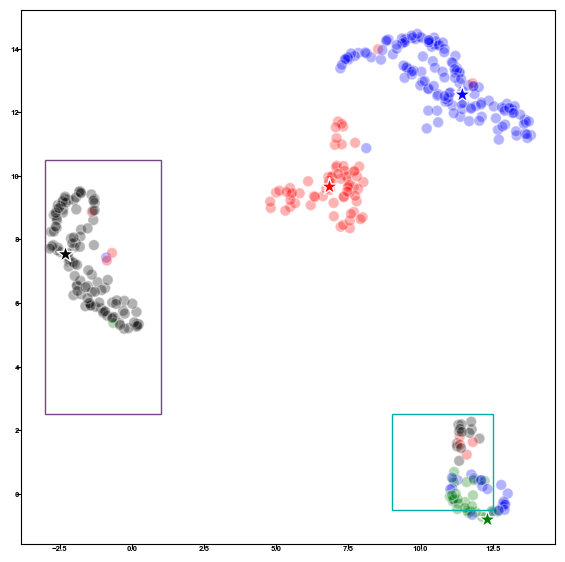

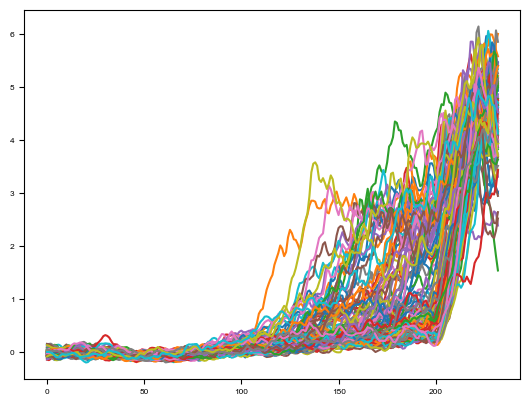

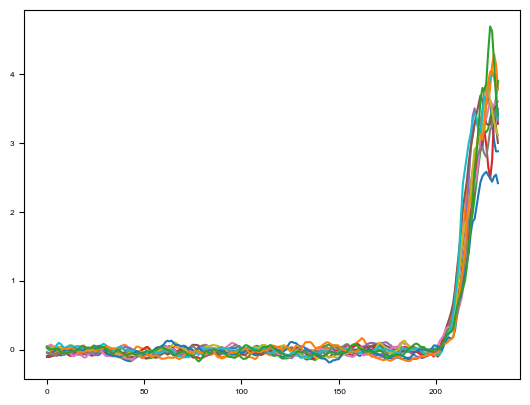

In [ ]:
# Figure 4 C 
for seed in [1]:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)   
    with plt.rc_context({"font.size": 2/0.35, "font.weight":"bold"}):
        pca,x,color,fig,ax = pca_plot(
            model,
            model.filter_fun2(filt_model),
            model.filter_fun2(filt_data_train),
            session_info_train,
            pca=False,
            trial_type=trial_type_pred_lick.cpu(),
            path=f"Figures/Figure4/figure4c.pdf",
            rand_state=seed,
            zoomed=True
        )
x = x[:-4]

from matplotlib import patches
xstart, ystart, lenx, leny = -3, 2.5, 4, 8
rec = patches.Rectangle((xstart,ystart), lenx, leny,facecolor='none',edgecolor="#754686")
ax.add_patch(rec)
active = (x[:,0]>xstart) & (x[:,0]<xstart+lenx) & (x[:,1]<ystart+leny) & (x[:,1]>ystart) & (color[:-4]=="black")

xstart, ystart, lenx, leny = 9, -0.5, 3.5, 3
rec = patches.Rectangle((xstart,ystart), lenx, leny,facecolor='none',edgecolor="#00afa7")
quiet = (x[:,0]>xstart) & (x[:,0]<xstart+lenx) & (x[:,1]<ystart+leny) & (x[:,1]>ystart) & (color[:-4]=="black")
ax.add_patch(rec)
fig.savefig("Figures/Figure4/umap.pdf")
plt.figure()
plt.plot(filt_jaw[:,active,0].cpu().numpy())
plt.figure()
plt.plot(filt_jaw[:,quiet,0].cpu().numpy())
plt.show()

In [ ]:
from utils.plot_utils import retrieve_spikes_trial_type
ff_model = model.filter_fun2(filt_model) 
ff_jaw = model.filter_fun2(filt_jaw) 
ff_time = model.filter_fun2(filt_time[:, None, None] )[:, 0, 0] 
ff_data_test = model.filter_fun2(filt_data_test) 
ff_data_train = model.filter_fun2(filt_data_train) 

with plt.rc_context({"lines.linewidth":1, "font.weight":"bold"}):
    for i in range(6):
        area_index = model.rsnn.area_index
        fig,ax = plot_with_size(40, 30)
        ax.plot(ff_time,ff_model[:,active][:,:, area_index==i].mean((1,2)).cpu(), alpha=0.7, color="#00afa7")
        ax.plot(ff_time,ff_model[:,quiet][:,:, area_index==i].mean((1,2)).cpu(), alpha=0.7, color="#754686")
        filt_data = retrieve_spikes_trial_type(ff_data_test, session_info_test, trial_type=1, active_quiet=1)
        ax.plot(ff_time, filt_data[...,area_index==i].nanmean((1,2)).cpu(), color="#00afa7",alpha=0.3)
        filt_data = retrieve_spikes_trial_type(ff_data_test, session_info_test, trial_type=1, active_quiet=0)
        ax.plot(ff_time, filt_data[...,area_index==i].nanmean((1,2)).cpu(), color="#754686", alpha=0.3)
        # ax.plot(ff_time, filt_data_test[:,quiet][..., area_index==i].mean((1,2)).cpu())
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        fig.savefig(f"Figures/Figure4/active_quiet_area_{i}.pdf", dpi=300,pad_inches=0, bbox_inches="tight")
    fig,ax = plot_with_size(40*4, 30*4)
    ax.plot(ff_time,ff_jaw[:,active].mean((1,2)).cpu())
    ax.plot(ff_time, ff_jaw[:,quiet].mean((1,2)).cpu())


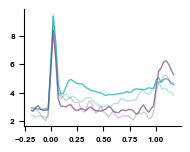

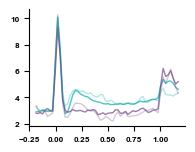

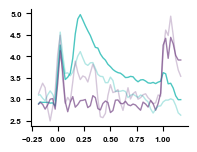

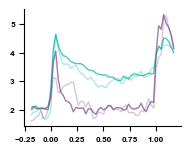

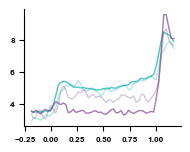

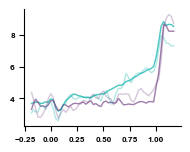

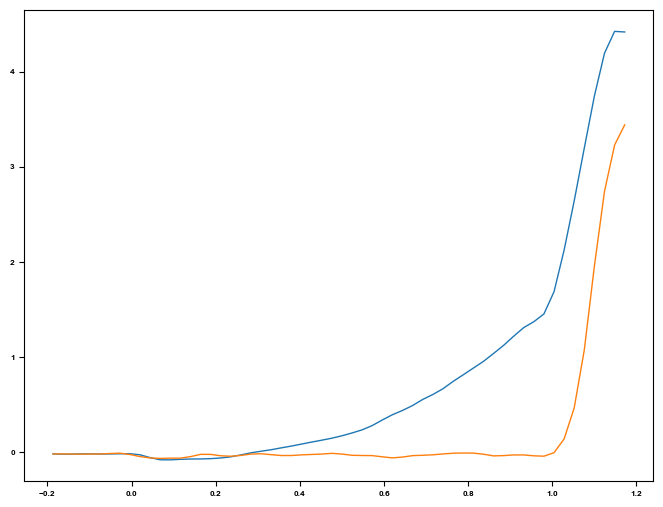

In [ ]:
plt.show()